# Imports

Import the necessary dependencies to use HEEM VQE, and perform the simulations on a fake quantum device. There will be three different simulations (TPB, Entangled Measurements, and Hardware Efficient Entangled Measurements). These three simulations will be run in parallel using the joblib module.

In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport VQE, GroupingAlgorithm, HEEM_VQE_Functions, utils

import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from utils import *
from qiskit import IBMQ
from qiskit import Aer
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.test.mock import FakeMelbourne
import os
from joblib import Parallel, delayed
from IPython.display import display, clear_output
from GroupingAlgorithm import grouping_shuffle
from tqdm.notebook import tqdm_notebook
from qiskit.visualization import plot_gate_map
from GroupingAlgorithm import grouping
from utils import Label2Chain
from joblib import Parallel, delayed
from time import time
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [2]:
# Define the callback to visualize the progress of VQE
def callback(evals, params, mean, deviation):  
    print("{}, {}".format(evals, mean))

# Define a function that run the VQE for a giben instance, and some quantum operators
def run_VQE(solver, qubitop):    
    evaluations = []
    solution = solver.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
    return solver.energies

# Setting the simulation

Load the QASM simulator and the fake quantum device, in this case ibmq 16 Melbourne. We also need the couping map of the device, the noise model and the gates that can be performed in this quantum chip. Latter we have to define the number of shots each circuit is measured, and the maximum number of iterations for the classical optimizer. After all that, we construct the quantum instance, and define the preference of basis for the grouping.

In [3]:
backend = Aer.get_backend('qasm_simulator')
device_backend = FakeMelbourne()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
NUM_SHOTS = 2 ** 13  # Number of shots for each circuit
maxiter = 300
qi = QuantumInstance(backend=backend, coupling_map=coupling_map, noise_model=noise_model, basis_gates=basis_gates, shots=NUM_SHOTS,
                     measurement_error_mitigation_cls=CompleteMeasFitter, cals_matrix_refresh_period=15)
basis = [4, 6, 7, 8, 9, 5, 3, 2, 1]

# Setting the VQE algorithm
We need to load the quantum operators for the LiH molecule and distance of interest. Later we try a Monte Carlo approach to randomize the order of the Paulis strings in order to find the best possible grouping with the connectivity and the basis preference defined above. Later we initialize the classical optimizer, in this case SPSA, and define some variational circuit and initialize all the angles in 0.1.

Them we initiaize a VQE instance for a TPB grouping, entangled measurement gruping without taking into account the coupling map, and the last one with HEEM. In order to verify the obtained energies, we compute the exact bond energy.

In [6]:
qubit_op, init_state = LiH(initial_state=True)
qubit_op = grouping_shuffle(qubit_op, basis, coupling_map, n_mc=1000)
num_qubits = qubit_op.num_qubits
optimizer = SPSA(maxiter=maxiter, last_avg=1)
ansatz = init_state.compose(EfficientSU2(num_qubits, ['ry', 'rz'], entanglement='linear', reps=1))
num_var = ansatz.num_parameters
initial_params = [0.1] *num_var

solver_TPB = VQE(ansatz, optimizer, initial_params, grouping='TPB',
                 quantum_instance=qi, callback=callback, order=basis)
solver_EM = VQE(ansatz, optimizer, initial_params, grouping='Entangled',
                quantum_instance=qi, callback=callback, order=basis)
solver_HEEM = VQE(ansatz, optimizer, initial_params, grouping='Entangled',
                  quantum_instance=qi, callback=callback, order=basis, conectivity=coupling_map)

solvers = [solver_TPB, solver_EM, solver_HEEM]

exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print('The exact minimum energy is: ', exact)

Computing optimal order:   0%|          | 0/1000 [00:00<?, ?it/s]

The original order gives 25 groups
The best order found gives 25 groups
The exact minimum energy is:  -1.0887060157347437


In [7]:
# Solve the VQE instances

start = time()
E_TPB, E_EM, E_HEEM = Parallel(n_jobs=3)(delayed(run_VQE)(solver, qubit_op) for solver in solvers)
print('VQE completed in {} min'.format((time() - start) / 60))

KeyboardInterrupt: 

# Save data

In [6]:
file = '../data/simulation_LiH_error_mitigation'
np.savez(file, NUM_SHOTS=NUM_SHOTS, maxiter=maxiter, basis=basis, E_TPB=E_TPB, E_EM=E_EM, E_HEEM=E_HEEM, E_EXACT=exact)

# Load and plot data

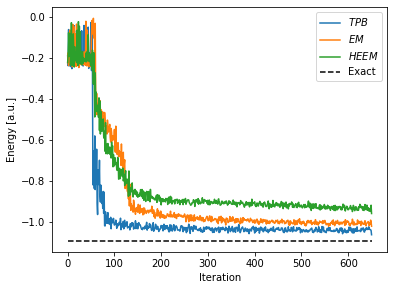

In [9]:
data = np.load(file + '.npz')

E_EXACT = data['E_EXACT']
E_TPB = data['E_TPB']
E_EM = data['E_EM']
E_HEEM = data['E_HEEM']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4.5))
ax.set_xlabel('Iteration')
ax.set_ylabel('Energy [a.u.]')

ax.plot(E_TPB)
ax.plot(E_EM)
ax.plot(E_HEEM)
ax.hlines(E_EXACT,0, len(E_TPB), color='black', linestyle='--')

ax.legend(['$TPB$', '$EM$', '$HEEM$', 'Exact'])

plt.savefig("../../Figures/simulation_LiH_mitigation.pdf")

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table